# Lasso Regression on SLDS

In [1]:
path = "/home/clewis/repos/realSpike/data/rb50_20250127/switching_plds/k2/"

In [2]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd
import h5py

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random

%matplotlib inline

# Get data

In [3]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_laser_rec_time', 'any', 'cue', 'cue_rec_time', 'cue_trial_time', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'single', 'totTime', 'trial_start']>


In [4]:
bin_size = 1

In [5]:
# save as a pickle file 
import pickle

In [6]:
filename = f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/{bin_size}ms_data.pkl"
# with open(filename, "wb") as file:
#     pickle.dump(model_data, file)

In [7]:
with open(filename, "rb") as file:
    model_data = pickle.load(file)

# Design the input matrix

In [8]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
stim_idxs = stim_idxs[stim_idxs > 150]
stim_idxs

array([151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220,
       221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289,
       290, 291, 292, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 330, 331, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [9]:
np.unique(data["pattern_id"][0, stim_idxs])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [10]:
stim_idxs.shape

(269,)

In [11]:
# get the pattern types

In [12]:
p_ids = np.unique(data["pattern_id"][0, stim_idxs])

p_ids

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [13]:
p_ids.shape

(27,)

## Get colors for plotting

In [14]:
c = [
    "maroon",
    "deeppink",
    "palevioletred", 
    "blue", 
    "orange", 
    "green", 
    "red", 
    "purple", 
    "brown", 
    "pink",
    "turquoise", 
    "olive", 
    "cyan", 
    "gold", 
    "lime", 
    "navy", 
    "magenta",
    "teal", 
    "royalblue", 
    "darkgreen",
    "dimgray",
    "darkgoldenrod",
    "midnightblue",
    "plum",
    "lime",
    "cadetblue",
    "steelblue",
    "peru"
]

In [15]:
len(c)

28

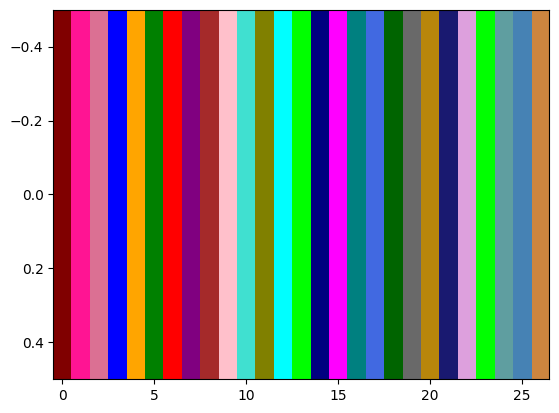

In [16]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c)

plt.imshow(np.arange(27).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

##  Reconstruct patterns

In [17]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [18]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data2 = {field: data_struct[field] for field in mat.dtype.names}

In [19]:
# visualize the patterns again
pattern_ids = list(np.unique(data2['pattern_id']))
len(pattern_ids)

30

In [20]:
from scipy.ndimage import zoom

In [21]:
reshape_size = 12

In [22]:
pattern_ids = list(np.unique(data2['pattern_id']))
all_patterns = list()
# pattern 0 = no laser
#all_patterns.append(np.zeros((12, 12)))
# pattern 1 = full field
#all_patterns.append(np.ones((12, 12)))
# pattern 2 = empty field 
#all_patterns.append(np.zeros((12, 12)))
for p_id in pattern_ids[3:]:
    ix = np.where(data2['pattern_id'] == p_id)[0][0].astype(np.int32)
    pattern = np.zeros((data2['pattern_xy'][ix][0].astype(np.int32), data2['pattern_xy'][ix][1].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = data2['pattern_fill'][0][ix]
    for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [23]:
len(all_patterns)

27

In [24]:
all_patterns[0]

array([[0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
       [0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.]])

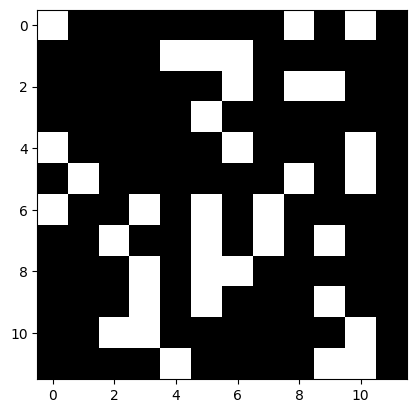

In [25]:
plt.imshow(all_patterns[0], cmap="binary")

In [26]:
model_data[0].shape

(105, 150)

In [27]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(5):
        nput[50 + z] = encoding

    inputs.append(nput)

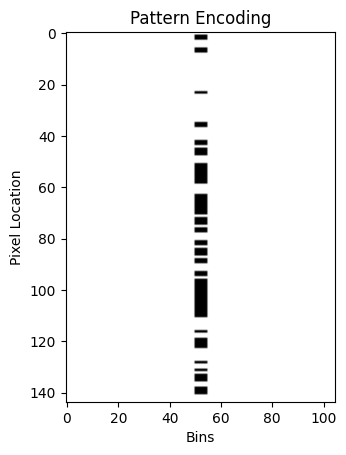

In [28]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [29]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.LDS(N=obs_dim, 
                # K=2, 
                D=state_dim, 
                M=144, emissions="poisson", 
                emission_kwargs=dict(link="softplus"),
                dynamics="diagonal_gaussian",
                transitions="inputdriven"
               )

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [30]:
# plot my elbos

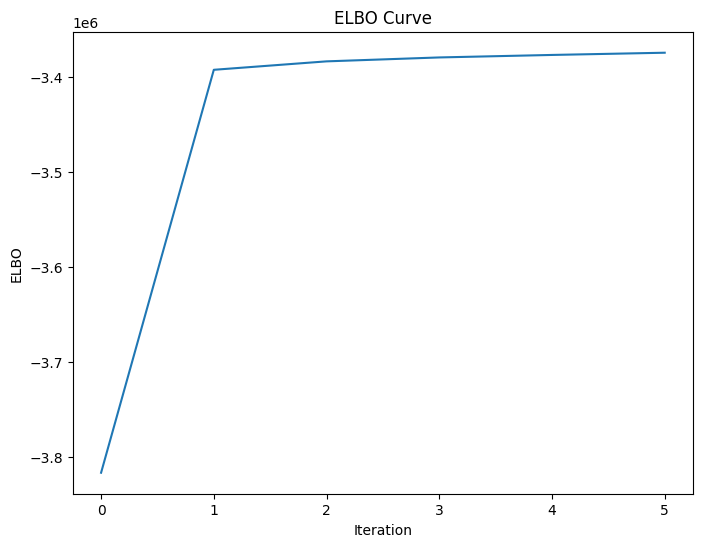

In [31]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

In [32]:
state_means = q.mean_continuous_states

In [34]:
As = plds.dynamics.As
As.shape

(1, 3, 3)

In [35]:
b = plds.dynamics.b
b.shape

(3,)

In [36]:
Bs = plds.dynamics.params[2]
Bs.shape

(1, 3, 144)

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import CenteredNorm

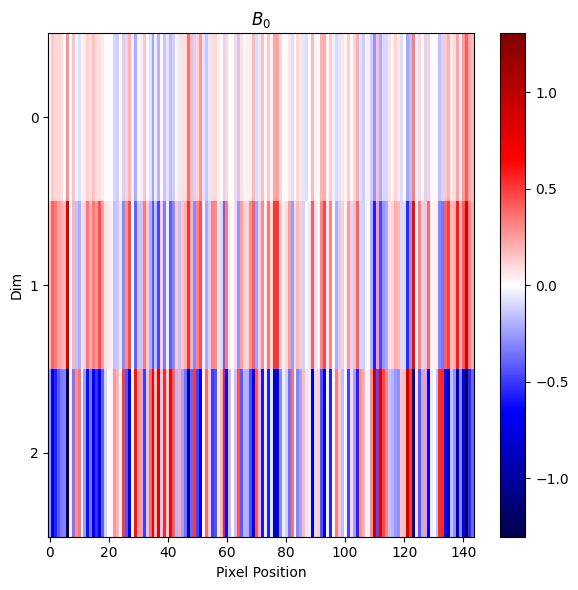

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


im = ax.matshow(Bs[0], cmap="seismic", aspect='auto', norm=CenteredNorm(vcenter=0))

ax.set_title(f"$B_{0}$")
ax.set_ylabel("Dim")
ax.set_xlabel("Pixel Position")

ax.xaxis.tick_bottom()

fig.colorbar(im, ax=ax)

plt.tight_layout()

#plt.savefig(f"{path}B.png")

plt.show()

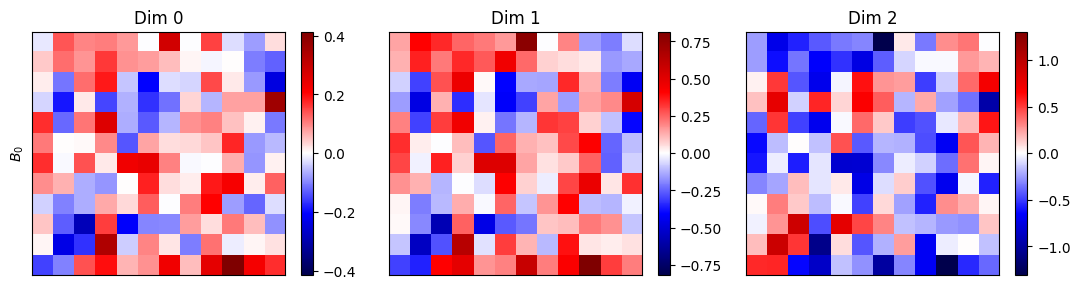

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    im = ax.matshow(Bs[0][i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))

    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    fig.colorbar(im, ax=ax)


axes[0].set_ylabel("$B_0$")

plt.tight_layout()

#plt.savefig(f"{path}B2.png")
plt.show()

# Run lasso regression for B_0

In [42]:
# Build predictors and responses
X_list = []
Y_list = []

for trial in range(len(state_means)):
    z_trial = state_means[i]
  #  z_trial = z_trial.T# (T, d)
    
    # compute residual: z_t - A z_{t-1} - b
    z_t = z_trial[1:]             # (T-1, d)
    z_tm1 = z_trial[:-1]          # (T-1, d)
    u_tm1 = inputs[trial][:-1]                # assume same u across trials
    
    residual = z_t - (z_tm1 @ As[0].T + b)  # (T-1, d)
    
    X_list.append(u_tm1)     # predictors
    Y_list.append(residual)  # targets

X = np.vstack(X_list)  # shape (trials*(T-1), input_dim)
Y = np.vstack(Y_list)  # shape (trials*(T-1), d)

In [43]:
X.shape

(27976, 144)

In [44]:
Y.shape

(27976, 3)

In [45]:
from sklearn.linear_model import Lasso, LassoCV

In [48]:
B_sparse0 = np.zeros((3, 144))

for i in range(3):
    model = LassoCV(cv=5, alphas=np.linspace(0.001, .5, 20), fit_intercept=False)  # cross-validated alpha
    #model = Lasso(alpha=0.001, fit_intercept=False)
    model.fit(X, Y[:, i])
    B_sparse0[i] = model.coef_
  #   lasso = Lasso(alpha=alpha, fit_intercept=True)
  # #  lasso.fit(U_all, Z_all[:, i])
  #   lasso.fit(X, Y[:, i])
  #   B_sparse[i, :] = lasso.coef_

/home/clewis/venvs/bah/lib64/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e+04, tolerance: 5.089e+02
  model = cd_fast.enet_coordinate_descent_gram(
/home/clewis/venvs/bah/lib64/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e+04, tolerance: 5.089e+02
  model = cd_fast.enet_coordinate_descent_gram(
/home/clewis/venvs/bah/lib64/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regul

Text(0.5, 1.0, '$B$')

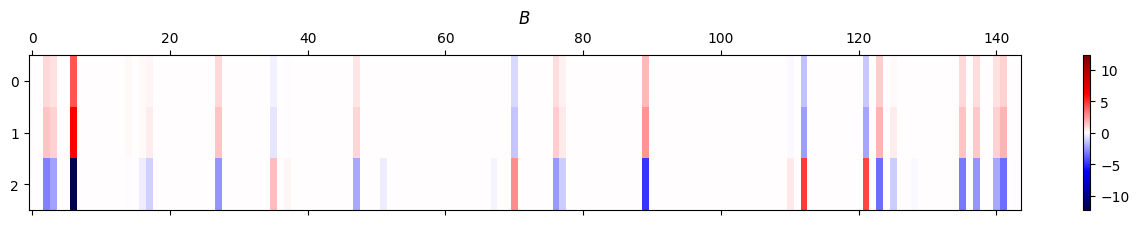

In [49]:
im = plt.matshow(B_sparse0, cmap='seismic', aspect='auto', norm=CenteredNorm())
plt.colorbar(im)

plt.title("$B$")

In [50]:
model.alpha_

np.float64(0.001)

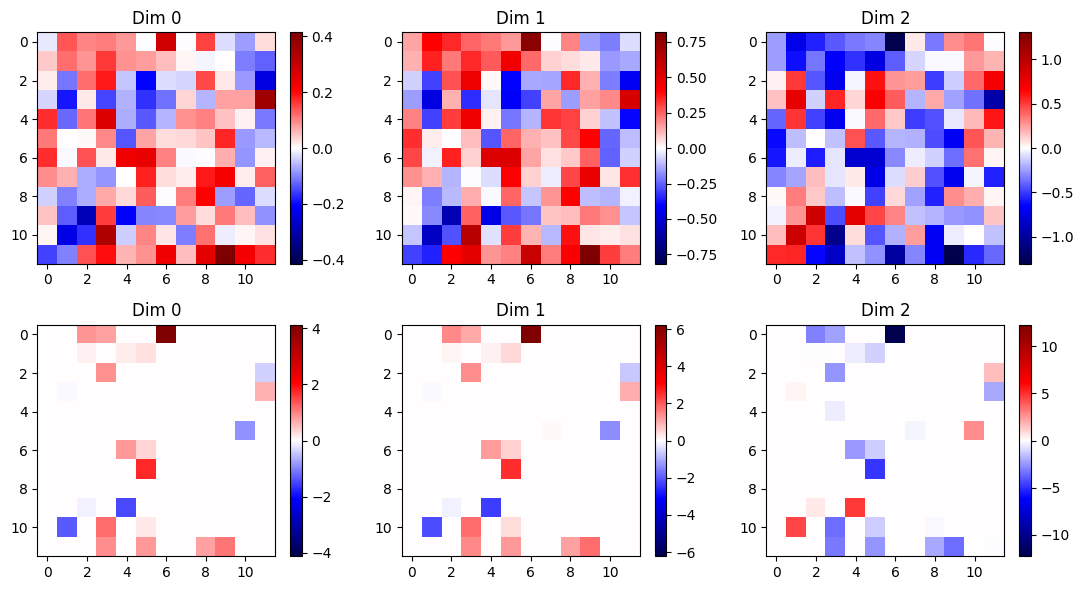

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()


for i in range(3):
    ax = axes[i]
    im = ax.matshow(Bs[0][i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))
    ax.set_title(f'Dim {i}')
    ax.xaxis.tick_bottom()
    fig.colorbar(im, ax=ax)

for i in range(3):
    ax = axes[i+3]
    im = ax.matshow(B_sparse0[i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm(vcenter=0))
    ax.xaxis.tick_bottom()
    fig.colorbar(im, ax=ax)
    ax.set_title(f'Dim {i}')
    ax.xaxis.tick_bottom()

plt.tight_layout()

#plt.savefig(f"{path}B_reduced_dim0.png")
plt.show()

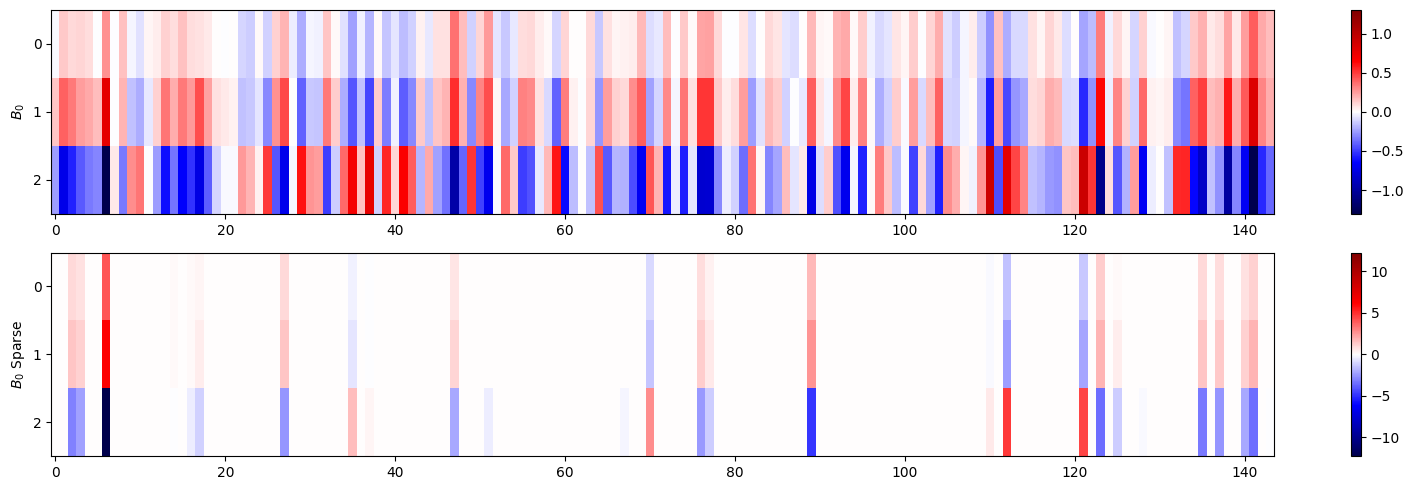

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(16, 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

d = [Bs[0], B_sparse0]

for i, ax in enumerate(axes):
    im = ax.matshow(d[i], cmap="seismic", aspect='auto', norm=CenteredNorm())

 #   ax.set_title(f"$B_{i}$")
   # ax.set_ylabel("Dim")
  #  ax.set_xlabel("Pixel Position")

    ax.xaxis.tick_bottom()

    fig.colorbar(im, ax=ax)



axes[0].set_ylabel("$B_0$")
axes[1].set_ylabel("$B_0$ Sparse")

plt.tight_layout()

#plt.savefig(f"{path}B_all.png")

plt.show()